In [ ]:
from azureml.core import Workspace, Dataset, Datastore

# subscription_id = ''
# resource_group = ''
# workspace_name = ''

# workspace = Workspace(subscription_id, resource_group, workspace_name)
# datastore = Datastore.get(workspace, "sp_data")

In [3]:
import torch
from os.path import join
import pandas as pd
import numpy as np
import importlib
import seaborn as sns

from stats import patient_stats
from common.utils import Data
from data.utils import Utilities

import matplotlib.pyplot as plt

In [4]:
MAN_TOKEN = 5
WOMAN_TOKEN = 19
CLS = True

## Patient Stats

In [ ]:
pats_ds = Dataset.Tabular.from_parquet_files(path=(datastore, 'CPMI_PatientInfo.parquet'))
pats = pats_ds.to_pandas_dataframe()
pats.head()

In [ ]:
print(len(pats))
print(pats.CPR_hash.nunique())
print(len(pats[pats.iloc[:,-1]=='Mand']))
print(len(pats[pats.iloc[:,-1]=='Kvinde']))

## Examine Features

In [5]:
feats_dir = join('../outputs','data_icd10', 'tokenized')
feats = torch.load(join(feats_dir, 'tokenized_pretrain.pt'))
pids = torch.load(join(feats_dir, 'pids_pretrain.pt'))
del feats['attention_mask']

In [6]:
vocab = torch.load(join(feats_dir, 'vocabulary.pt'))
tdata = Data(features=feats, pids=pids, vocabulary=vocab)

## Age at last event

In [7]:
def iterate_patients(features, feat, is_man=None):
    # Simplify gender_token assignment using ternary expression
    gender_token = None if is_man is None else MAN_TOKEN if is_man else WOMAN_TOKEN
    i = 0
    if CLS:
        gender_index = 1
    else:
        gender_index = 0
    for pat, tokens in zip(features[feat], features['concept']):
        if gender_token is None or tokens[gender_index] == gender_token:
            yield pat
def get_ages_last_encounter(features, feat, is_man=None):
    ages = [ages[-1] for ages in iterate_patients(features, feat, is_man)]
    return np.array(ages)
# this should be done as special case in utils

In [8]:
# Using the new function to get age arrays
age_last_encounter = get_ages_last_encounter(feats, 'age')
age_last_encounter_m = get_ages_last_encounter(feats, 'age', is_man=True)
age_last_encounter_f = get_ages_last_encounter(feats, 'age', is_man=False)
np.median(age_last_encounter), np.percentile(age_last_encounter, 25), np.percentile(age_last_encounter, 75)

(41.980000000000004, 22.2225, 57.6375)

## Outcomes stats

In [9]:
test_outcome = torch.load("../outputs/data_icd10/outcomes/TEST_OUTCOME/TEST_OUTCOME.pt")
outcomes_dic = {'test':test_outcome}
ordered_outcomes = Utilities.filter_and_order_outcomes(outcomes_dic, tdata.pids)
tdata.outcomes = ordered_outcomes

In [12]:
censoring_times = [0, 3,]  # Define your censoring times in months
cutoffs = [1,5,10]
patient_stats_ = patient_stats.PatientStats(tdata, censoring_times, CLS=True)
patient_stats_.process_patients()
patient_stats_.convert_to_numpy()
patient_stats_.compute_cumulative_stats(min_codes_list= cutoffs)

# Access the statistics
stats_dic = patient_stats_.stats_dic

In [13]:
stats_dic

{'ages': {'TEST_OUTCOME': array([26.84, 22.84, 27.88, 15.06,  1.02, 42.83, 52.36,  7.32, 11.98,
         49.39, 52.88, 21.31, 22.51, 11.06,  0.85, 15.69, 31.41,  7.15,
         44.17, 33.52, 52.7 , 55.34,  2.74,  9.83, 19.75, 33.98,  8.74,
         25.75, 14.72, 38.41, 36.49, 44.42, 22.25, 11.84, 53.84, 15.27,
         28.98, 26.48, 10.54, 52.53, 72.82, 48.85, 13.09, 49.07, 54.41,
         26.58,  9.45, 61.35, 26.77, 19.5 , 51.3 ,  6.38, 20.13, 20.19,
         20.19,  9.51,  8.28, 62.8 , 10.78,  2.57, 54.24, 55.56, 29.12,
         69.19,  6.41,  3.39, 52.65, 22.08,  9.24, 31.64,  8.46, 65.14,
         33.31, 17.02, 28.64, 22.29, 35.86, 11.93, 56.68, 11.58,  0.97,
         36.72, 60.43, 14.86,  2.81,  4.04, 18.27, 27.99, 23.07, 22.99,
         46.27, 40.76, 77.98]),
  'TEST_CENSOR': array([ 1.3140e+01,  8.5800e+01,  1.4890e+01,  2.4070e+01,  2.0430e+01,
          2.9170e+01,  2.7250e+01,  1.3070e+01,  1.0000e-01,  7.1000e-01,
          8.8230e+01, -1.0000e+00,  7.4230e+01,  4.5330e+01, 

## Visualize

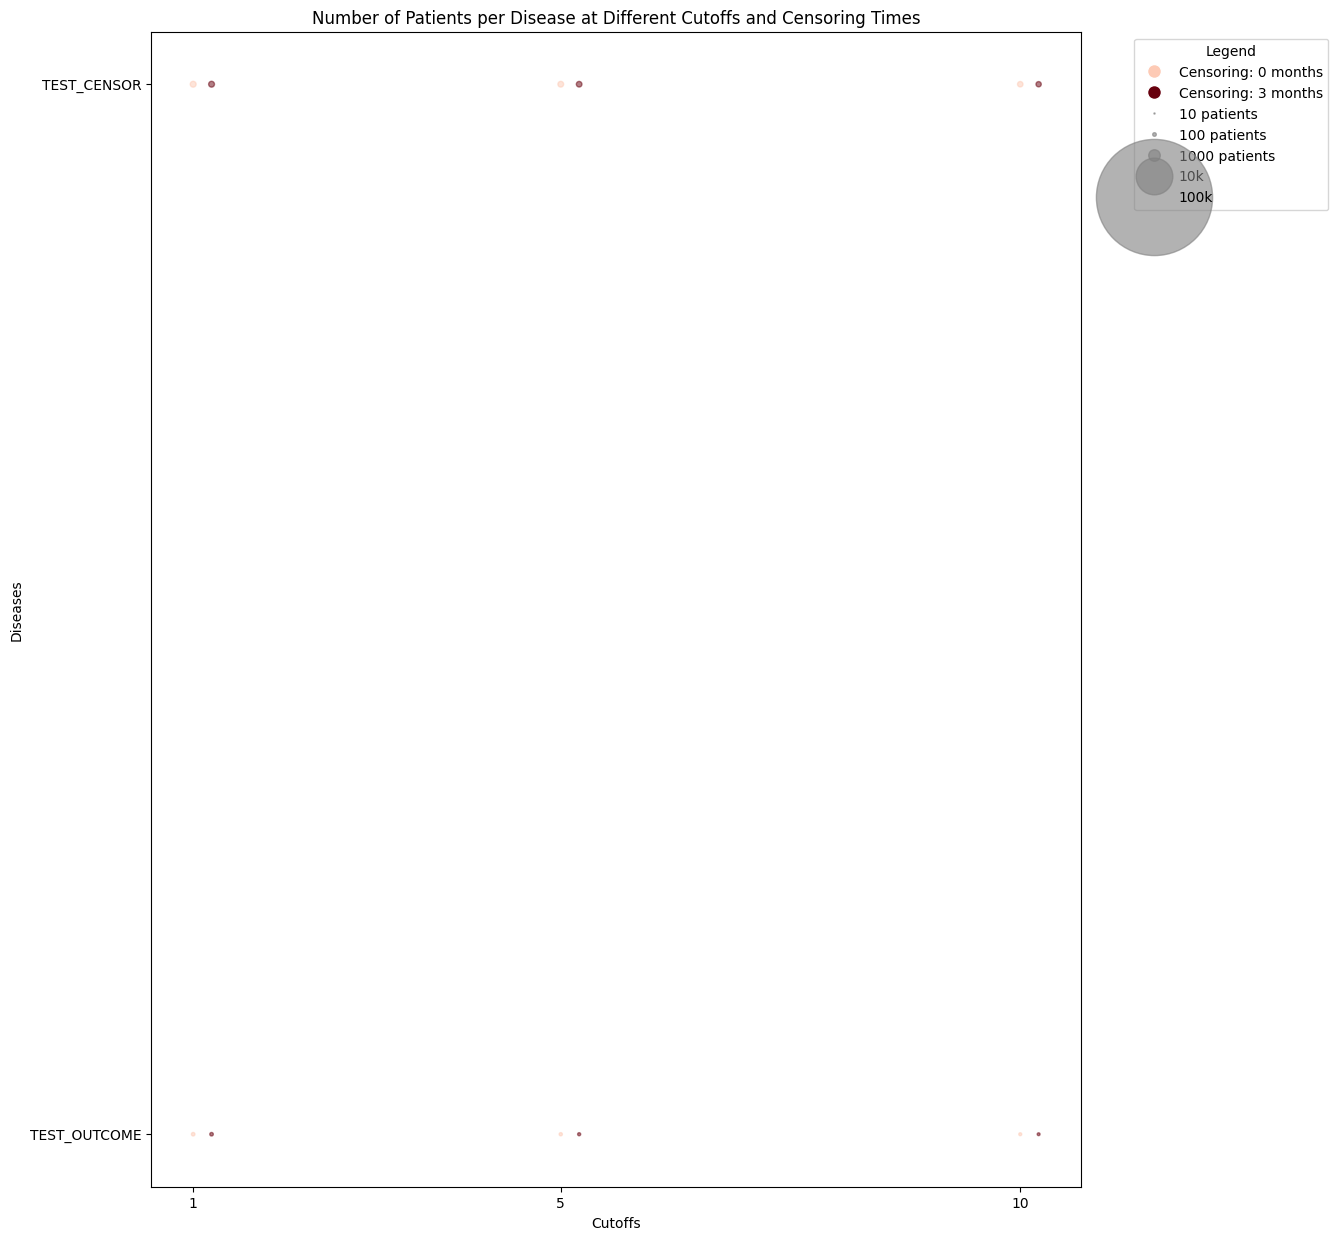

In [26]:
# Prepare data for plotting
x_values = []
y_values = []
areas = []  # Area of scatter plot points (e.g., number of patients)
colors = []

diseases = list(stats_dic['patient_counts_min1'].keys())

# Color map
cmap = plt.cm.get_cmap('Reds')
color_range = cmap(np.linspace(0.2, 1, len(censoring_times)))

for cutoff in cutoffs:
    key = f'patient_counts_min{cutoff}'
    for i, disease in enumerate(diseases):
        for censor_idx, censor_time in enumerate(censoring_times):
            count = stats_dic[key][disease].get(censor_time, [0])
            x_values.append(cutoff + 0.2 * censor_idx)  # Slight offset for each censoring time
            y_values.append(i)
            areas.append(count * .07)  # Adjust multiplier as needed for visibility
            colors.append(color_range[censor_idx])


# Plotting
plt.figure(figsize=(12, 15))
scatter = plt.scatter(x_values, y_values, s=areas, c=colors, alpha=0.5)
plt.xticks(cutoffs)
plt.yticks(range(len(diseases)), diseases)
plt.xlabel('Cutoffs')
plt.ylabel('Diseases')
plt.title('Number of Patients per Disease at Different Cutoffs and Censoring Times')

# Create a legend for censoring times
legend_labels_censor = [f'Censoring: {time} months' for time in censoring_times]
legend_elements_censor = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                                     markersize=10, markerfacecolor=color) for label, color in zip(legend_labels_censor, color_range)]

# Create a legend for sizes (using example sizes)
size_labels = ['10 patients', '100 patients', '1000 patients', '10k', '100k']  # Example size labels
size_values = [10, 100, 1000, 10000, 100000]  # Example sizes corresponding to the labels
legend_elements_size = [plt.Line2D([0], [0], marker='o', color='grey', label=label,
                                  markersize=np.sqrt(size*.07) , alpha=0.6, linestyle="None") for label, size in zip(size_labels, size_values)]

# Adding both legends to the plot
plt.legend(handles=legend_elements_censor + legend_elements_size, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [14]:
# Preparing data for plotting
age_data = [(outcome, value) for outcome, values in stats_dic['ages'].items() for value in values]
traj_len_data = [(outcome, value) for outcome, values in stats_dic['trajectory'].items() for value in values[0]]  # 0 censoring
seq_len_data = [(outcome, value) for outcome, values in stats_dic['sequence_length'].items() for value in values[0]]  # 0 censoring
visits_data = [(outcome, value) for outcome, values in stats_dic['visits'].items() for value in values[0]]  # 0 censoring

# Convert to DataFrame
df_age = pd.DataFrame(age_data, columns=['Outcome', 'Age'])
df_traj_len = pd.DataFrame(traj_len_data, columns=['Outcome', 'Trajectory Length'])
df_seq_len = pd.DataFrame(seq_len_data, columns=['Outcome', 'Sequence Length'])
df_visits = pd.DataFrame(visits_data, columns=['Outcome', 'Visits'])

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

sns.violinplot(x='Age', y='Outcome', data=df_age, ax=axs[0], orient='h')
axs[0].set_title('Age Distribution per Outcome')

sns.violinplot(x='Trajectory Length', y='Outcome', data=df_traj_len, ax=axs[1], orient='h')
axs[1].set_title('Trajectory Length Distribution per Outcome (0 Censoring)')

sns.violinplot(x='Sequence Length', y='Outcome', data=df_seq_len, ax=axs[2], orient='h')
axs[2].set_title('Sequence Length Distribution per Outcome (0 Censoring)')

sns.violinplot(x='Visits', y='Outcome', data=df_visits, ax=axs[3], orient='h')
axs[3].set_title('Visits Distribution per Outcome (0 Censoring)')
for ax in axs:
    ax.set_xas
plt.tight_layout()
plt.show()

: 

In [8]:
a = set(('abd', 'def'))
b = set(('a', 'c'))
a.update(b)

In [11]:
import torch

In [34]:
pids01 = torch.load(r'C:\Users\fjn197\PhD\projects\PHAIR\pipelines\ehr2vec\ehr2vec\ehr2vec\outputs\pretraining\behrt_test\pids_val.pt')
pids02 = torch.load(r'C:\Users\fjn197\PhD\projects\PHAIR\pipelines\ehr2vec\ehr2vec\ehr2vec\outputs\pretraining\behrt_test_2\pids_val.pt')

In [35]:
pids01==pids02

True